In [222]:
pip install category_encoders

In [223]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
import numpy as np

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns



In [224]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [225]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

### 0）overview

In [226]:
train.dtypes

id                          int64
Decision                    int64
Host_response_time         object
Host_is_superhost          object
Host_has_profile_pic       object
Host_identity_verified     object
Neighbourhood               int64
Property_type              object
Room_type                  object
Accommodates                int64
Bathrooms_text             object
Bedrooms                  float64
Beds                      float64
Essentials                  int64
Cooking                     int64
Balcony                     int64
Parking                     int64
Price                      object
Number_of_reviews           int64
Review_scores_rating      float64
Instant_bookable           object
Month                      object
dtype: object

In [227]:
train.head()

,id,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,1 bath,3.0,3.0,5,5,1,1,$164.00,90,4.93,t,August
1,2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,1 bath,1.0,1.0,5,4,1,1,$101.00,522,4.69,t,June
2,3,0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,1 private bath,1.0,1.0,5,3,1,1,$32.00,35,4.83,f,June
3,4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,2 baths,2.0,5.0,5,5,0,1,$381.00,11,5.00,t,September
4,5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,2 baths,3.0,4.0,5,5,1,1,$238.00,63,4.70,f,July


In [228]:
train.shape

(7471, 22)

In [229]:
train['Price']

0       $164.00 
1       $101.00 
2        $32.00 
3       $381.00 
4       $238.00 
          ...   
7466    $852.00 
7467    $127.00 
7468    $325.00 
7469    $239.00 
7470    $186.00 
Name: Price, Length: 7471, dtype: object

In [230]:
#converting price into numbers
train['Price'] = train['Price'].map(lambda x: x.lstrip('$').replace(' ', '').replace(',', ''))
train['Price'] = train['Price'].astype(float)
train['Month'] = train['Month'].map(lambda x: x.replace('June', '6').replace('July', '7').replace('August', '8').replace('September','9'))

#### Bathrooms_txt

In [231]:
train['Bathrooms_text'].unique()

array(['1 bath', '1 private bath', '2 baths', '1.5 baths', '3 baths',
       '2.5 baths', '6 baths', '5 baths', '1 shared bath', '3.5 baths',
       '1.5 shared baths', '4.5 baths', '2.5 shared baths', '4 baths',
       'Private half-bath', 'Half-bath', '9 baths', '2 shared baths',
       '6.5 baths', '0 shared baths', '0 baths', '5.5 baths', '7 baths'],
      dtype=object)

In [232]:
pd.crosstab(index = train['Bathrooms_text'], columns = train['Decision'],normalize = 'index')

Decision,0,1
Bathrooms_text,,
0 baths,0.583333,0.416667
0 shared baths,1.000000,0.000000
1 bath,0.376213,0.623787
1 private bath,0.297744,0.702256
1 shared bath,0.430279,0.569721
1.5 baths,0.467626,0.532374
1.5 shared baths,0.440000,0.560000
2 baths,0.347951,0.652049
2 shared baths,0.321429,0.678571


In [233]:
# combining small categories
train.replace(dict.fromkeys(['5 baths','5.5 baths', '6 baths', '6.5 baths', '7 baths', '9 baths'], 'Above 4'))
train.replace(dict.fromkeys(['0 baths','0 shared baths'], 'None'))
train.replace(dict.fromkeys(['1 baths','1 shared baths', '1.5 baths','1.5 shared baths', \
                             '2 baths', '2.5 baths', '2.5 shared baths', '3 baths', '3.5 baths',
                             '4 baths', '4.5 baths'], 'Below 4'))
train.replace(dict.fromkeys(['Half-bath', 'Private half-bath', '1 private bath'], 'Private'))

,id,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,1 bath,3.0,3.0,5,5,1,1,164.0,90,4.93,t,8
1,2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,1 bath,1.0,1.0,5,4,1,1,101.0,522,4.69,t,6
2,3,0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,Private,1.0,1.0,5,3,1,1,32.0,35,4.83,f,6
3,4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,2 baths,2.0,5.0,5,5,0,1,381.0,11,5.00,t,9
4,5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,2 baths,3.0,4.0,5,5,1,1,238.0,63,4.70,f,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7466,7467,1,within an hour,f,t,f,28804,Entire house,Entire home/apt,10,4 baths,4.0,6.0,2,5,1,1,852.0,2,5.00,t,6
7467,7468,1,within an hour,t,t,t,28801,Entire guest suite,Entire home/apt,2,1 bath,1.0,1.0,5,3,1,1,127.0,106,4.98,f,9
7468,7469,1,within an hour,t,t,f,28803,Entire residential home,Entire home/apt,10,2.5 baths,3.0,5.0,5,5,1,1,325.0,70,4.93,f,8
7469,7470,1,within an hour,t,t,f,28801,Entire loft,Entire home/apt,4,1 bath,1.0,2.0,5,5,0,0,239.0,20,4.95,f,7


### Property type

In [234]:
train['Property_type'].unique()

array(['Entire cabin', 'Entire house', 'Private room in bungalow',
       'Entire condominium (condo)', 'Entire residential home',
       'Entire rental unit', 'Entire bungalow', 'Entire guest suite',
       'Entire apartment', 'Entire condominium', 'Tiny house',
       'Private room in residential home', 'Entire townhouse',
       'Room in boutique hotel', 'Private room in guest suite',
       'Entire cottage', 'Private room in bed and breakfast',
       'Private room in house', 'Casa particular (Cuba)', 'Campsite',
       'Entire guesthouse', 'Private room', 'Private room in camper/rv',
       'Entire place', 'Entire chalet', 'Camper/RV',
       'Room in bed and breakfast', 'Shared room in hostel', 'Farm stay',
       'Entire loft', 'Private room in treehouse', 'Yurt',
       'Private room in rental unit', 'Bus', 'Private room in cottage',
       'Entire villa', 'Private room in farm stay',
       'Private room in hostel', 'Private room in apartment', 'Treehouse',
       'Private roo

In [235]:
train['Property_type'].value_counts()

Entire house                           1132
Entire guest suite                     1118
Entire residential home                1082
Entire apartment                        550
Entire rental unit                      536
Private room in house                   355
Private room in residential home        331
Entire cottage                          269
Entire guesthouse                       246
Entire cabin                            216
Entire condominium (condo)              192
Entire condominium                      192
Entire bungalow                         187
Private room in bed and breakfast       146
Entire townhouse                        137
Entire loft                              98
Tiny house                               98
Private room in bungalow                 77
Private room in guest suite              70
Room in bed and breakfast                56
Campsite                                 34
Room in boutique hotel                   34
Camper/RV                       

In [236]:
pd.crosstab(index = train['Property_type'], columns = train['Decision'], normalize = 'index')

Decision,0,1
Property_type,,
Bus,0.000000,1.000000
Camper/RV,0.343750,0.656250
Campsite,0.117647,0.882353
Casa particular,0.500000,0.500000
Casa particular (Cuba),0.750000,0.250000
Entire apartment,0.430909,0.569091
Entire bungalow,0.572193,0.427807
Entire cabin,0.388889,0.611111
Entire chalet,0.250000,0.750000


In [237]:
pd.crosstab(index = train['Property_type'], columns = train['Decision'])

Decision,0,1
Property_type,,
Bus,0,12
Camper/RV,11,21
Campsite,4,30
Casa particular,1,1
Casa particular (Cuba),3,1
Entire apartment,237,313
Entire bungalow,107,80
Entire cabin,84,132
Entire chalet,8,24


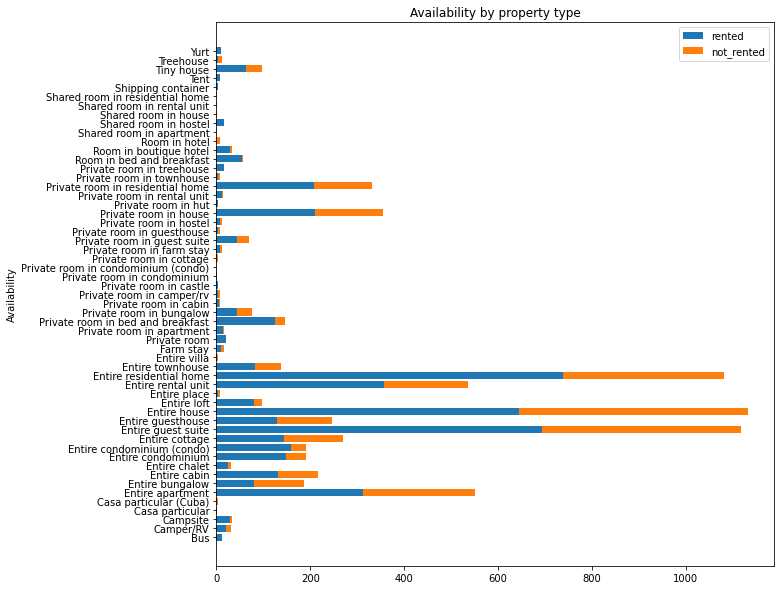

In [238]:
bar_labels = pd.crosstab(index = train['Property_type'], columns = train['Decision']).index
rented = pd.crosstab(index = train['Property_type'], columns = train['Decision'])[1]
not_rented = pd.crosstab(index = train['Property_type'], columns = train['Decision'])[0]
#men_std = [2, 3, 4, 1, 2]
#women_std = [3, 5, 2, 3, 3]
#width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(10,10))
plt.barh(bar_labels, rented, label='rented')
plt.barh(bar_labels, not_rented, left=rented,
       label='not_rented')

plt.ylabel('Availability')
plt.title('Availability by property type')
plt.legend()

plt.show()

In [239]:
#find categories that contains less than 2% of the entire data
property_freq = (train['Property_type'].value_counts())/train.shape[0]
botton_decile = 0.02
less_freq_properties = property_freq[property_freq<=botton_decile]

In [240]:
less_freq_properties

Private room in bed and breakfast      0.019542
Entire townhouse                       0.018338
Entire loft                            0.013117
Tiny house                             0.013117
Private room in bungalow               0.010307
Private room in guest suite            0.009370
Room in bed and breakfast              0.007496
Campsite                               0.004551
Room in boutique hotel                 0.004551
Camper/RV                              0.004283
Entire chalet                          0.004283
Private room                           0.002677
Private room in apartment              0.002142
Private room in treehouse              0.002142
Shared room in hostel                  0.002142
Farm stay                              0.002142
Private room in rental unit            0.002008
Private room in farm stay              0.001606
Bus                                    0.001606
Treehouse                              0.001606
Private room in hostel                 0

In [241]:
train.loc[train['Property_type'].isin(less_freq_properties.index.tolist()), 'Property_type'] = 'Special'

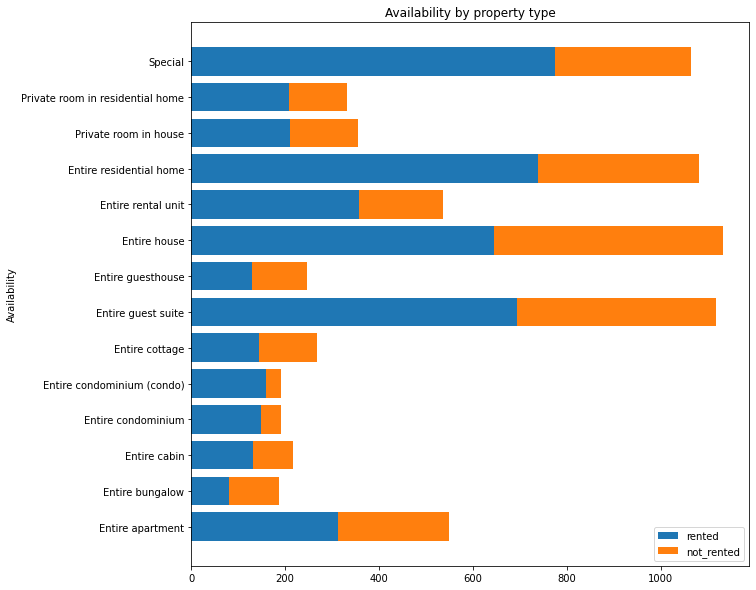

In [242]:
bar_labels = pd.crosstab(index = train['Property_type'], columns = train['Decision']).index
rented = pd.crosstab(index = train['Property_type'], columns = train['Decision'])[1]
not_rented = pd.crosstab(index = train['Property_type'], columns = train['Decision'])[0]
#men_std = [2, 3, 4, 1, 2]
#women_std = [3, 5, 2, 3, 3]
#width = 0.35       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(10,10))
plt.barh(bar_labels, rented, label='rented')
plt.barh(bar_labels, not_rented, left=rented,
       label='not_rented')

plt.ylabel('Availability')
plt.title('Availability by property type')
plt.legend()

plt.show()

### 2) Missing Values

In [243]:
#the number of rows that contains missing
train.isnull().any(axis=1).sum()

1605

In [244]:
train.isnull().sum()

id                          0
Decision                    0
Host_response_time        858
Host_is_superhost          96
Host_has_profile_pic       96
Host_identity_verified     96
Neighbourhood               0
Property_type               0
Room_type                   0
Accommodates                0
Bathrooms_text              0
Bedrooms                  585
Beds                       13
Essentials                  0
Cooking                     0
Balcony                     0
Parking                     0
Price                       0
Number_of_reviews           0
Review_scores_rating      395
Instant_bookable            0
Month                       0
dtype: int64

In [245]:
train.head()

,id,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,1 bath,3.0,3.0,5,5,1,1,164.0,90,4.93,t,8
1,2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,1 bath,1.0,1.0,5,4,1,1,101.0,522,4.69,t,6
2,3,0,within a few hours,t,t,t,28806,Special,Private room,1,1 private bath,1.0,1.0,5,3,1,1,32.0,35,4.83,f,6
3,4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,2 baths,2.0,5.0,5,5,0,1,381.0,11,5.00,t,9
4,5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,2 baths,3.0,4.0,5,5,1,1,238.0,63,4.70,f,7


In [246]:
train['Host_response_time'].value_counts()

within an hour        5818
within a few hours     509
within a day           262
a few days or more      24
Name: Host_response_time, dtype: int64

In [247]:
pd.crosstab(index = train['Host_response_time'], columns = train['Decision'],normalize = 'index')

Decision,0,1
Host_response_time,,
a few days or more,0.791667,0.208333
within a day,0.687023,0.312977
within a few hours,0.567780,0.432220
within an hour,0.295119,0.704881


In [248]:
train[train['Host_response_time'].isnull()]['Decision'].value_counts()

0    531
1    327
Name: Decision, dtype: int64

In [249]:
train['Bedrooms'].value_counts()

1.0    3546
2.0    1806
3.0     977
4.0     367
5.0      97
6.0      57
7.0      20
8.0      12
9.0       4
Name: Bedrooms, dtype: int64

In [250]:
pd.crosstab(index = train['Bedrooms'], columns = train['Decision'],normalize = 'index')

Decision,0,1
Bedrooms,,
1.0,0.365200,0.634800
2.0,0.389812,0.610188
3.0,0.372569,0.627431
4.0,0.269755,0.730245
5.0,0.298969,0.701031
6.0,0.228070,0.771930
7.0,0.300000,0.700000
8.0,0.500000,0.500000
9.0,0.750000,0.250000


In [251]:
train[train['Bedrooms'].isnull()]['Decision'].value_counts()

1    368
0    217
Name: Decision, dtype: int64

In [252]:
train['Review_scores_rating'].value_counts()

5.00    1576
4.96     342
4.97     342
4.98     312
4.93     302
        ... 
4.10       1
4.51       1
2.33       1
4.31       1
4.21       1
Name: Review_scores_rating, Length: 86, dtype: int64

In [253]:
pd.crosstab(index = train['Review_scores_rating'], columns = train['Decision'],normalize = 'index')

Decision,0,1
Review_scores_rating,,
0.00,1.000000,0.000000
1.00,0.000000,1.000000
2.33,0.000000,1.000000
3.00,0.000000,1.000000
3.33,0.000000,1.000000
...,...,...
4.96,0.362573,0.637427
4.97,0.309942,0.690058
4.98,0.358974,0.641026


In [254]:
train[train['Review_scores_rating'].isnull()]['Decision'].value_counts()

0    211
1    184
Name: Decision, dtype: int64

In [255]:
encode = ce.OrdinalEncoder(cols=['Host_response_time', 'Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified', 'Property_type', 'Room_type', 'Bathrooms_text', 'Instant_bookable'])

In [256]:
X_train = train.drop(['Decision'], axis=1)
y_train = train['Decision']

In [257]:
encode.fit(X_train)
X_train = encode.fit_transform(X_train)
X_train.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,1,1,1,28806,1,1,6,1,3.0,3.0,5,5,1,1,164.0,90,4.93,1,8
1,2,1,1,1,1,28804,2,1,4,1,1.0,1.0,5,4,1,1,101.0,522,4.69,1,6
2,3,2,1,1,1,28806,3,2,1,2,1.0,1.0,5,3,1,1,32.0,35,4.83,2,6
3,4,1,1,1,1,28803,4,1,8,3,2.0,5.0,5,5,0,1,381.0,11,5.00,1,9
4,5,1,1,1,1,28805,2,1,6,3,3.0,4.0,5,5,1,1,238.0,63,4.70,2,7


In [258]:
col_names = list(X_train.columns)

### 2) Imputation

In [259]:
#use regression for imputation
imp = IterativeImputer(max_iter=100, random_state=0)

In [260]:
imp.fit(X_train)

IterativeImputer(max_iter=100, random_state=0)

In [261]:
X_train = imp.transform(X_train)

In [262]:
X_train.shape

(7471, 21)

In [263]:
pd.DataFrame(X_train).isnull().sum().sum()

0

In [264]:
X_train = pd.DataFrame(X_train)
X_train.columns = col_names

In [265]:
X_train.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1.0,1.0,1.0,1.0,1.0,28806.0,1.0,1.0,6.0,1.0,3.0,3.0,5.0,5.0,1.0,1.0,164.0,90.0,4.93,1.0,8.0
1,2.0,1.0,1.0,1.0,1.0,28804.0,2.0,1.0,4.0,1.0,1.0,1.0,5.0,4.0,1.0,1.0,101.0,522.0,4.69,1.0,6.0
2,3.0,2.0,1.0,1.0,1.0,28806.0,3.0,2.0,1.0,2.0,1.0,1.0,5.0,3.0,1.0,1.0,32.0,35.0,4.83,2.0,6.0
3,4.0,1.0,1.0,1.0,1.0,28803.0,4.0,1.0,8.0,3.0,2.0,5.0,5.0,5.0,0.0,1.0,381.0,11.0,5.00,1.0,9.0
4,5.0,1.0,1.0,1.0,1.0,28805.0,2.0,1.0,6.0,3.0,3.0,4.0,5.0,5.0,1.0,1.0,238.0,63.0,4.70,2.0,7.0


In [266]:
X_train.isnull().any(axis=1).sum()

0

#### Split Train & Validation

In [267]:
train = X_train

In [268]:
train['Decision'] = y_train

In [269]:
train_train, train_vali = train_test_split(train, test_size = 1471, random_state = 42)

In [270]:
train_train

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month,Decision
45,46.0,1.0,1.0,1.0,1.0,28804.0,5.0,1.0,10.0,6.0,3.0,4.0,5.0,5.0,1.0,1.0,390.0,94.0,4.97,1.0,8.0,1
3779,3780.0,1.0,1.0,1.0,1.0,28801.0,10.0,1.0,4.0,1.0,1.0,2.0,5.0,5.0,1.0,1.0,259.0,66.0,5.00,1.0,7.0,0
4761,4762.0,1.0,1.0,1.0,2.0,28801.0,3.0,2.0,3.0,2.0,1.0,1.0,4.0,0.0,0.0,1.0,182.0,1.0,5.00,2.0,6.0,0
5190,5191.0,1.0,2.0,1.0,2.0,28804.0,9.0,1.0,4.0,1.0,2.0,2.0,5.0,5.0,1.0,1.0,128.0,41.0,4.59,2.0,6.0,0
6149,6150.0,1.0,1.0,1.0,1.0,28803.0,13.0,2.0,2.0,9.0,1.0,1.0,5.0,2.0,1.0,1.0,33.0,140.0,4.86,1.0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,5192.0,1.0,1.0,1.0,1.0,28801.0,2.0,1.0,6.0,1.0,2.0,2.0,5.0,2.0,1.0,1.0,147.0,56.0,4.84,1.0,6.0,1
5226,5227.0,4.0,1.0,1.0,1.0,28801.0,2.0,1.0,6.0,3.0,3.0,3.0,4.0,5.0,1.0,1.0,275.0,1.0,5.00,2.0,6.0,0
5390,5391.0,1.0,1.0,1.0,1.0,28805.0,6.0,1.0,2.0,1.0,1.0,1.0,5.0,5.0,0.0,1.0,66.0,113.0,4.98,1.0,9.0,1
860,861.0,1.0,1.0,1.0,1.0,28732.0,3.0,1.0,4.0,1.0,1.0,2.0,5.0,5.0,1.0,1.0,117.0,15.0,4.93,1.0,8.0,1


In [271]:
train_vali

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month,Decision
4562,4563.0,1.0,1.0,1.0,1.0,28801.0,3.0,2.0,2.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,173.0,5.0,5.000000,1.0,7.0,1
576,577.0,1.0,2.0,1.0,1.0,28806.0,2.0,1.0,10.0,5.0,4.0,4.0,5.0,4.0,1.0,1.0,304.0,163.0,4.780000,1.0,7.0,1
4335,4336.0,1.0,2.0,1.0,2.0,28801.0,3.0,2.0,2.0,1.0,1.0,1.0,5.0,5.0,0.0,1.0,314.0,0.0,4.703204,1.0,7.0,1
2268,2269.0,1.0,2.0,1.0,2.0,28803.0,1.0,1.0,8.0,3.0,4.0,4.0,3.0,3.0,1.0,1.0,305.0,7.0,4.430000,1.0,6.0,1
3362,3363.0,3.0,1.0,1.0,1.0,28801.0,8.0,1.0,4.0,1.0,2.0,2.0,5.0,3.0,0.0,1.0,151.0,107.0,4.920000,1.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,381.0,1.0,2.0,1.0,1.0,28704.0,2.0,1.0,12.0,5.0,3.0,6.0,4.0,4.0,0.0,1.0,275.0,26.0,4.730000,1.0,6.0,1
3809,3810.0,1.0,1.0,1.0,1.0,28806.0,12.0,1.0,6.0,3.0,2.0,3.0,5.0,5.0,1.0,1.0,270.0,19.0,4.840000,2.0,7.0,1
3933,3934.0,1.0,1.0,1.0,1.0,28805.0,6.0,1.0,6.0,3.0,2.0,3.0,5.0,5.0,1.0,1.0,156.0,33.0,4.880000,1.0,9.0,0
3542,3543.0,1.0,2.0,1.0,2.0,28804.0,12.0,1.0,4.0,3.0,2.0,3.0,5.0,1.0,0.0,1.0,165.0,56.0,4.800000,1.0,7.0,0


In [272]:
X_train_train = train_train.drop(['Decision'], axis=1)
y_train_train = train_train['Decision']

In [273]:
X_train_train.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
45,46.0,1.0,1.0,1.0,1.0,28804.0,5.0,1.0,10.0,6.0,3.0,4.0,5.0,5.0,1.0,1.0,390.0,94.0,4.97,1.0,8.0
3779,3780.0,1.0,1.0,1.0,1.0,28801.0,10.0,1.0,4.0,1.0,1.0,2.0,5.0,5.0,1.0,1.0,259.0,66.0,5.00,1.0,7.0
4761,4762.0,1.0,1.0,1.0,2.0,28801.0,3.0,2.0,3.0,2.0,1.0,1.0,4.0,0.0,0.0,1.0,182.0,1.0,5.00,2.0,6.0
5190,5191.0,1.0,2.0,1.0,2.0,28804.0,9.0,1.0,4.0,1.0,2.0,2.0,5.0,5.0,1.0,1.0,128.0,41.0,4.59,2.0,6.0
6149,6150.0,1.0,1.0,1.0,1.0,28803.0,13.0,2.0,2.0,9.0,1.0,1.0,5.0,2.0,1.0,1.0,33.0,140.0,4.86,1.0,6.0


In [274]:
y_train_train.head()

45      1
3779    0
4761    0
5190    0
6149    0
Name: Decision, dtype: int64

In [275]:
X_train_vali = train_vali.drop(['Decision'], axis = 1)
y_train_vali = train_vali['Decision']

In [276]:
X_train_vali.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
4562,4563.0,1.0,1.0,1.0,1.0,28801.0,3.0,2.0,2.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0,173.0,5.0,5.000000,1.0,7.0
576,577.0,1.0,2.0,1.0,1.0,28806.0,2.0,1.0,10.0,5.0,4.0,4.0,5.0,4.0,1.0,1.0,304.0,163.0,4.780000,1.0,7.0
4335,4336.0,1.0,2.0,1.0,2.0,28801.0,3.0,2.0,2.0,1.0,1.0,1.0,5.0,5.0,0.0,1.0,314.0,0.0,4.703204,1.0,7.0
2268,2269.0,1.0,2.0,1.0,2.0,28803.0,1.0,1.0,8.0,3.0,4.0,4.0,3.0,3.0,1.0,1.0,305.0,7.0,4.430000,1.0,6.0
3362,3363.0,3.0,1.0,1.0,1.0,28801.0,8.0,1.0,4.0,1.0,2.0,2.0,5.0,3.0,0.0,1.0,151.0,107.0,4.920000,1.0,9.0


In [277]:
y_train_vali.head()

4562    1
576     1
4335    1
2268    1
3362    1
Name: Decision, dtype: int64

## Model 1: Random Forest

In [ ]:
#check for missing value
X_train_train.isna().any()

id                        False
Host_response_time        False
Host_is_superhost         False
Host_has_profile_pic      False
Host_identity_verified    False
Neighbourhood             False
Property_type             False
Room_type                 False
Accommodates              False
Bathrooms_text            False
Bedrooms                  False
Beds                      False
Essentials                False
Cooking                   False
Balcony                   False
Parking                   False
Price                     False
Number_of_reviews         False
Review_scores_rating      False
Instant_bookable          False
Month                     False
dtype: bool

In [278]:
RF_kaggle = RandomForestClassifier(n_estimators=100, max_depth = 100, \
                            random_state=0)
%time
RF_kaggle.fit(X_train_train, y_train_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


RandomForestClassifier(max_depth=100, random_state=0)

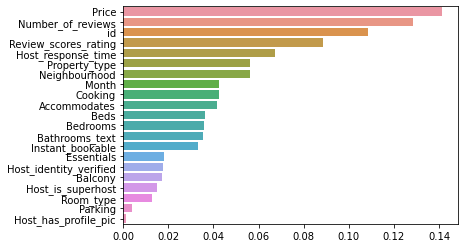

In [279]:
feature_scores = pd.Series(RF_kaggle.feature_importances_, index=X_train_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.show()

In [280]:
y_pred_train_train = RF_kaggle.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train)

1.0

In [281]:
y_pred_train_vali = RF_kaggle.predict(X_train_vali)
accuracy_score(y_train_vali, y_pred_train_vali)

0.8021753908905507

## Tuning Model

In [282]:
rf_regressor = RandomForestRegressor()

In [283]:
%time
# define search grid in a dictionry
serach_grid_RF = {
'n_estimators': [50, 100, 200, 300, 400, 500, 600],
'max_depth': [10, 20, 30, 50, 100]
}

# use k - fold CV to find the best parameters
cv_RF = GridSearchCV(rf_regressor, param_grid = serach_grid_RF, cv = 10, n_jobs = -1)

# Use the best parameters for the model
RF_tuned = cv_RF.fit(X_train_train, y_train_train)

# tuned parameters
print(RF_tuned.best_params_)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
{'max_depth': 50, 'n_estimators': 500}


In [284]:
%time
RF_tuned = RandomForestClassifier(n_estimators=500, max_depth = 50, \
                            random_state=0)
RF_tuned.fit(X_train_train, y_train_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)

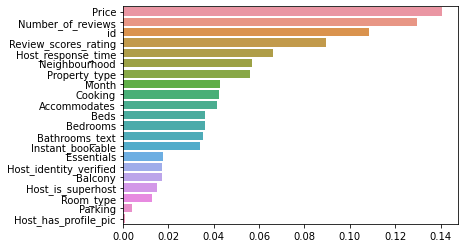

In [285]:
feature_scores = pd.Series(RF_tuned.feature_importances_, index=X_train_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.show()

In [286]:
y_pred_train_train = RF_tuned.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train)

1.0

In [287]:
y_pred_train_vali = RF_tuned.predict(X_train_vali)
accuracy_score(y_train_vali, y_pred_train_vali)

0.8055744391570361

#### Predict Test

In [296]:
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test.isnull().any(axis = 1).sum()
test_colnames = test.columns

In [297]:
test['Price'] = test['Price'].map(lambda x: x.lstrip('$').replace(' ', '').replace(',', ''))
test['Price'] = test['Price'].astype(float)
test['Month'] = test['Month'].map(lambda x: x.replace('June', '6').replace('July', '7').replace('August', '8').replace('September','9'))
test.loc[test['Property_type'].isin(less_freq_properties.index.tolist()), 'Property_type'] = 'Special'


In [298]:
test.replace(dict.fromkeys(['5 baths','5.5 baths', '6 baths', '6.5 baths', '7 baths', '9 baths'], 'Above 4'))
test.replace(dict.fromkeys(['0 baths','0 shared baths'], 'None'))
test.replace(dict.fromkeys(['1 baths','1 shared baths', '1.5 baths','1.5 shared baths', \
                             '2 baths', '2.5 baths', '2.5 shared baths', '3 baths', '3.5 baths',
                             '4 baths', '4.5 baths'], 'Below 4'))
test.replace(dict.fromkeys(['Half-bath', 'Private half-bath', '1 private bath'], 'Private'))

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,NaN,t,t,t,28806,Special,Private room,1,Private,1.0,1.0,4,3,1,1,58.0,137,4.85,f,9
1,2,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,5,5,1,1,76.0,573,4.93,t,6
2,3,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,5,5,1,1,76.0,590,4.93,t,8
3,4,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,5,5,1,1,76.0,600,4.93,t,9
4,5,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,1.0,1.0,5,5,1,1,76.0,581,4.93,t,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,2436,within an hour,f,t,f,28806,Entire guesthouse,Entire home/apt,6,3 baths,2.0,0.0,1,0,0,1,115.0,0,NaN,t,9
2436,2437,within an hour,t,t,t,28803,Entire residential home,Entire home/apt,9,3 baths,3.0,6.0,5,5,1,1,123.0,0,NaN,t,9
2437,2438,within a few hours,t,t,t,28806,Entire residential home,Entire home/apt,14,4 baths,4.0,7.0,4,1,0,1,681.0,0,NaN,t,9
2438,2439,within an hour,t,t,t,28704,Private room in residential home,Private room,2,Private,1.0,1.0,5,2,0,1,54.0,0,NaN,t,9


In [299]:
test = encode.transform(test)
test = imp.transform(test)

In [300]:
test = pd.DataFrame(test, columns= test_colnames)

In [293]:
y_pred_test_rf = RF_tuned.predict(test)
y_pred_test_rf = pd.DataFrame(y_pred_test_rf, columns=['Decision'])
y_pred_test_rf['id'] = test['id']
y_pred_test_rf = y_pred_test_rf[['id', 'Decision']]
y_pred_test_rf['id'] = y_pred_test_rf['id'].astype(int)
y_pred_test_rf['Decision'].astype(int)
y_pred_test_rf.dtypes

id          int64
Decision    int64
dtype: object

In [295]:
y_pred_test_rf.to_csv('y_pred_test_rf_tuned', index=False)

## Model 2: Boosting

In [301]:
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='linear')

In [302]:
from sklearn.tree import DecisionTreeClassifier

In [303]:
from sklearn.linear_model import LogisticRegression

### Logistic Regression

In [304]:
%time
ABC_LR = AdaBoostClassifier(n_estimators=100, base_estimator = LogisticRegression(), learning_rate=1, random_state=0)
ABC_LR.fit(X_train_train, y_train_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=100, random_state=0)

In [305]:
y_pred_train_train_LR = ABC_LR.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train_LR)

0.6548333333333334

### SVM

In [306]:
ABC_SVM = AdaBoostClassifier(n_estimators=2, base_estimator = svc, learning_rate=1, random_state=0)
ABC_SVM.fit(X_train_train, y_train_train)

KeyboardInterrupt: ignored

In [160]:
y_pred_train_train_SVM = ABC_SVM.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train_SVM)

0.6798333333333333

### Decision Tree

In [307]:
%time
ABC_DT = AdaBoostClassifier(n_estimators=100, base_estimator = DecisionTreeClassifier(max_depth=4), learning_rate=1, random_state=0)
ABC.fit(X_train_train, y_train_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=1, n_estimators=100, random_state=0)

In [308]:
y_pred_train_train_DT = ABC.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train_DT)

0.9668333333333333

Tuning Model

In [309]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [310]:
ab_regressor = AdaBoostRegressor()

In [317]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74#
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore depths from 1 to 10
	for i in range(1,11):
		# define base model
		base = DecisionTreeClassifier(max_depth=i)
		# define ensemble model
		models[str(i)] = AdaBoostClassifier(n_estimators = 100, base_estimator=base)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [318]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_train, y_train_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 0.722 (0.021)
>2 0.729 (0.021)
>3 0.728 (0.016)
>4 0.723 (0.018)
>5 0.714 (0.018)
>6 0.721 (0.017)
>7 0.734 (0.014)
>8 0.752 (0.016)
>9 0.761 (0.015)
>10 0.769 (0.016)


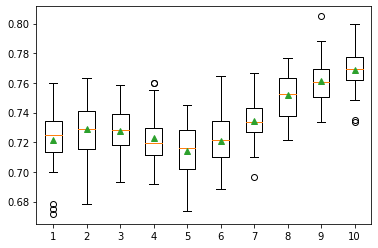

In [319]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [320]:
%time
ABC_tuned = AdaBoostClassifier(n_estimators = 100, base_estimator=DecisionTreeClassifier(max_depth=10), learning_rate= 1)
ABC_tuned.fit(X_train_train, y_train_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=1, n_estimators=100)

In [321]:
y_pred_train_train_ABC_tuned = ABC_tuned.predict(X_train_train)
accuracy_score(y_train_train, y_pred_train_train_ABC_tuned)

1.0

In [322]:
y_pred_train_vali_ABC_tuned = ABC_tuned.predict(X_train_vali)
accuracy_score(y_train_vali, y_pred_train_vali_ABC_tuned)

0.7892590074779062

In [205]:
y_pred_test_abc = ABC_tuned.predict(test)
y_pred_test_abc = pd.DataFrame(y_pred_test_abc, columns=['Decision'])
y_pred_test_abc['id'] = test['id']
y_pred_test_abc = y_pred_test_abc[['id', 'Decision']]
y_pred_test_abc['id'] = y_pred_test_abc['id'].astype(int)
y_pred_test_abc['Decision'].astype(int)
y_pred_test_abc.dtypes

id          int64
Decision    int64
dtype: object

In [207]:
y_pred_test_abc.to_csv('y_pred_test_abc_tuned', index=False)

## Model3: Feed-Foward NN

In [323]:
# https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [324]:
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler    

In [325]:
scaler = StandardScaler()
X_train_train_s = scaler.fit_transform(X_train_train)
X_train_vali_s = scaler.transform(X_train_vali)

In [326]:
EPOCHS = 50
BATCH_SIZE = 500
LEARNING_RATE = 0.1

In [327]:
#to convert the data in the form of pytorch data set so that we can use 
#data loader
class TrainData(data_utils.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train_train_s), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(data_utils.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_train_vali_s))

In [328]:
train_loader = data_utils.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data_utils.DataLoader(dataset=test_data, batch_size=1)

In [329]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
 
        self.l1 = nn.Linear(21, 80)  
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(80, 80)
        self.batchnorm = nn.BatchNorm1d(80)
        self.l3 = nn.Linear(80, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        x = self.batchnorm(x)
        x = self.l3(x)

        return x


In [330]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [331]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWitLhLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


BinaryClassification(
  (l1): Linear(in_features=21, out_features=80, bias=True)
  (tanh): Tanh()
  (l2): Linear(in_features=80, out_features=80, bias=True)
  (batchnorm): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=80, out_features=1, bias=True)
)


In [332]:
#output classification accuracy in the training loop
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [333]:
%time
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 001: | Loss: 0.86309 | Acc: 53.833
Epoch 002: | Loss: 0.67390 | Acc: 62.750
Epoch 003: | Loss: 0.66206 | Acc: 63.667
Epoch 004: | Loss: 0.66037 | Acc: 63.583
Epoch 005: | Loss: 0.65902 | Acc: 63.583
Epoch 006: | Loss: 0.65758 | Acc: 63.750
Epoch 007: | Loss: 0.65398 | Acc: 63.667
Epoch 008: | Loss: 0.65436 | Acc: 63.750
Epoch 009: | Loss: 0.65395 | Acc: 63.833
Epoch 010: | Loss: 0.65270 | Acc: 63.833
Epoch 011: | Loss: 0.65264 | Acc: 63.667
Epoch 012: | Loss: 0.65214 | Acc: 63.500
Epoch 013: | Loss: 0.65042 | Acc: 64.000
Epoch 014: | Loss: 0.64633 | Acc: 63.667
Epoch 015: | Loss: 0.64312 | Acc: 63.667
Epoch 016: | Loss: 0.64305 | Acc: 63.917
Epoch 017: | Loss: 0.63714 | Acc: 64.583
Epoch 018: | Loss: 0.63124 | Acc: 64.333
Epoch 019: | Loss: 0.62206 | Acc: 65.500
Epoch 020: | Loss: 0.62455 | Acc: 65.833
Epoch 021: | Loss: 0.60970 | Acc: 66.583
Epoch 022: | Loss: 0.60928 | Acc: 67.250
Epoch 023: | Loss: 0.59741 | Acc: 6

In [334]:
#test loop
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [335]:
from sklearn.metrics import confusion_matrix

In [336]:
confusion_matrix(y_train_vali, y_pred_list)

array([[166, 355],
       [322, 628]])